ARIMA 모델은 단변량 모델이고, **VAR 모델이 다변량 모델**이라고 해서 VAR 모델로 진행!

- VAR 참고: https://dining-developer.tistory.com/32
- 캐글 코드 참고:
  - https://www.kaggle.com/code/prakharprasad/time-series-vector-autoregression/notebook
  - https://www.kaggle.com/code/sagivmal/var-prediction-on-coronavirus-italy/notebook

In [ ]:
# 그래프 한글폰트 깨짐 해결 
## 맨 처음에 다른 코드들 실행하기 전에 현재 셀 실행해서 폰트 설치한 뒤 '런타임 다시 시작' 후 
## 현재 셀은 다시 주석 처리해서 실행하지 말고 다음 셀부터 실행하면 됨

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (6,792 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family']='NanumBarunGothic'
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tools.eval_measures import rmse, aic

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filepath='/content/drive/Shareddrives/팔당댐/combined_data/combined_train_test_filled_cleansed.csv'

In [ ]:
# 전처리한 데이터 불러오기
df=pd.read_csv(filepath,index_col='ymdhm',parse_dates=['ymdhm'])
df

,swl,inf,sfw,ecpc,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,fw_1018680,wl_1018683,fw_1018683,wl_1019630,fw_1019630,rf_10184100,rf_10184110,rf_10184140
ymdhm,,,,,,,,,,,,,,,,,
2012-05-01 00:00:00,24.800,555.00,219.07,24.93,555.00,445.0,310.7,469.05,300.2,0.0,290.0,729.80,275.3,540.18,0.0,0.0,0.0
2012-05-01 00:10:00,24.794,464.60,218.86,25.15,562.90,449.0,314.7,498.00,300.2,0.0,290.0,731.48,275.3,540.18,0.0,0.0,0.0
2012-05-01 00:20:00,24.789,478.10,218.69,25.31,576.40,451.0,313.7,490.68,301.2,0.0,290.0,726.42,275.3,540.18,0.0,0.0,0.0
2012-05-01 00:30:00,24.789,464.80,218.69,25.31,563.10,452.0,311.7,476.21,301.2,0.0,290.0,726.42,276.3,552.17,0.0,0.0,0.0
2012-05-01 00:40:00,24.789,478.10,218.69,25.31,576.40,450.0,311.7,476.21,301.2,0.0,291.0,707.17,277.3,564.29,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-18 23:10:00,25.040,259.23,212.86,31.14,259.23,510.0,288.0,319.84,295.0,0.0,299.0,-456.41,306.0,974.40,0.0,0.0,0.0
2022-07-18 23:20:00,25.040,260.46,212.86,31.14,260.46,492.0,287.0,314.01,303.0,0.0,304.0,-717.30,308.0,1006.88,0.0,0.0,0.0
2022-07-18 23:30:00,25.040,259.37,212.86,31.14,259.37,475.0,299.0,387.55,307.0,0.0,309.0,-843.37,310.0,1039.90,0.0,0.0,0.0


# Basic EDA
- https://www.kaggle.com/code/sagivmal/var-prediction-on-coronavirus-italy/notebook 참고

In [ ]:
df.describe()

,swl,inf,sfw,ecpc,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,fw_1018680,wl_1018683,fw_1018683,wl_1019630,fw_1019630,rf_10184100,rf_10184110,rf_10184140
count,276336.000000,276336.000000,276336.000000,276336.000000,276336.000000,276336.000000,276336.000000,276336.000000,276336.000000,276336.0,276336.000000,276336.000000,276336.000000,276336.000000,276336.000000,276336.000000,276336.000000
mean,25.079251,548.548083,219.425047,24.575537,542.036770,345.631700,329.232797,746.826551,316.071760,0.0,312.590404,600.970021,299.979812,1056.807758,0.034074,0.038265,0.035985
std,0.146126,1110.978412,9.912109,9.911699,1104.317791,174.250734,76.559900,1077.388189,67.495669,0.0,63.883452,1376.848129,51.442783,1428.279212,0.338607,0.370553,0.360769
min,23.993000,-807.500000,176.380000,2.150000,-222.000000,39.000000,259.700000,243.290000,246.200000,0.0,247.000000,-3522.710000,241.300000,212.040000,0.000000,0.000000,0.000000
25%,24.980000,127.417500,211.770000,14.670000,132.000000,192.000000,287.700000,319.840000,278.200000,0.0,275.000000,205.082500,267.300000,449.120000,0.000000,0.000000,0.000000
50%,25.100000,249.570000,217.630000,26.370000,174.980000,324.000000,307.000000,441.000000,297.200000,0.0,295.000000,355.980000,286.300000,679.420000,0.000000,0.000000,0.000000
75%,25.190000,530.000000,229.330000,32.230000,505.000000,487.000000,342.700000,725.690000,330.200000,0.0,328.000000,709.710000,316.300000,1142.220000,0.000000,0.000000,0.000000
max,25.449000,25991.500000,241.850000,67.620000,25791.500000,842.000000,1287.700000,9405.640000,1146.200000,0.0,1080.000000,25289.170000,843.300000,29854.120000,24.000000,21.000000,24.000000


In [ ]:
# fw_1018680는 원래 없는 자료이므로 삭제
df.drop('fw_1018680', axis=1, inplace=True)

- 상호연관성이 높은 swl, sfw, ecpc 중에서 sfw 변수만 사용
- 상호연관성이 높은 tototf, inf 중에서 tototf 변수만 사용
- tide_level 변수 사용
- fw, wl, 강수량 변수 모두 사용

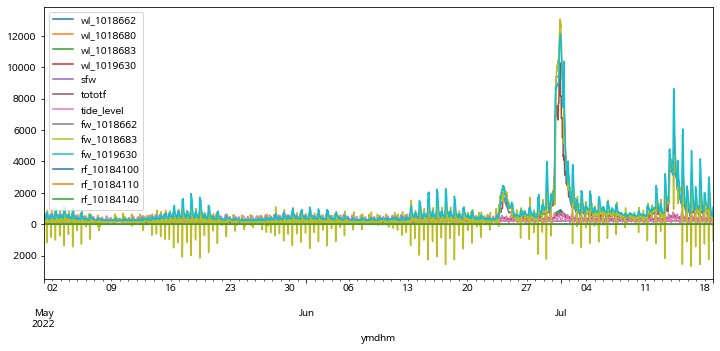

In [ ]:
# 2022년

df.loc['2022',['wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630', 
               'sfw', 'tototf', 'tide_level', 'fw_1018662', 'fw_1018683', 'fw_1019630',
               'rf_10184100', 'rf_10184110',	'rf_10184140']].plot();

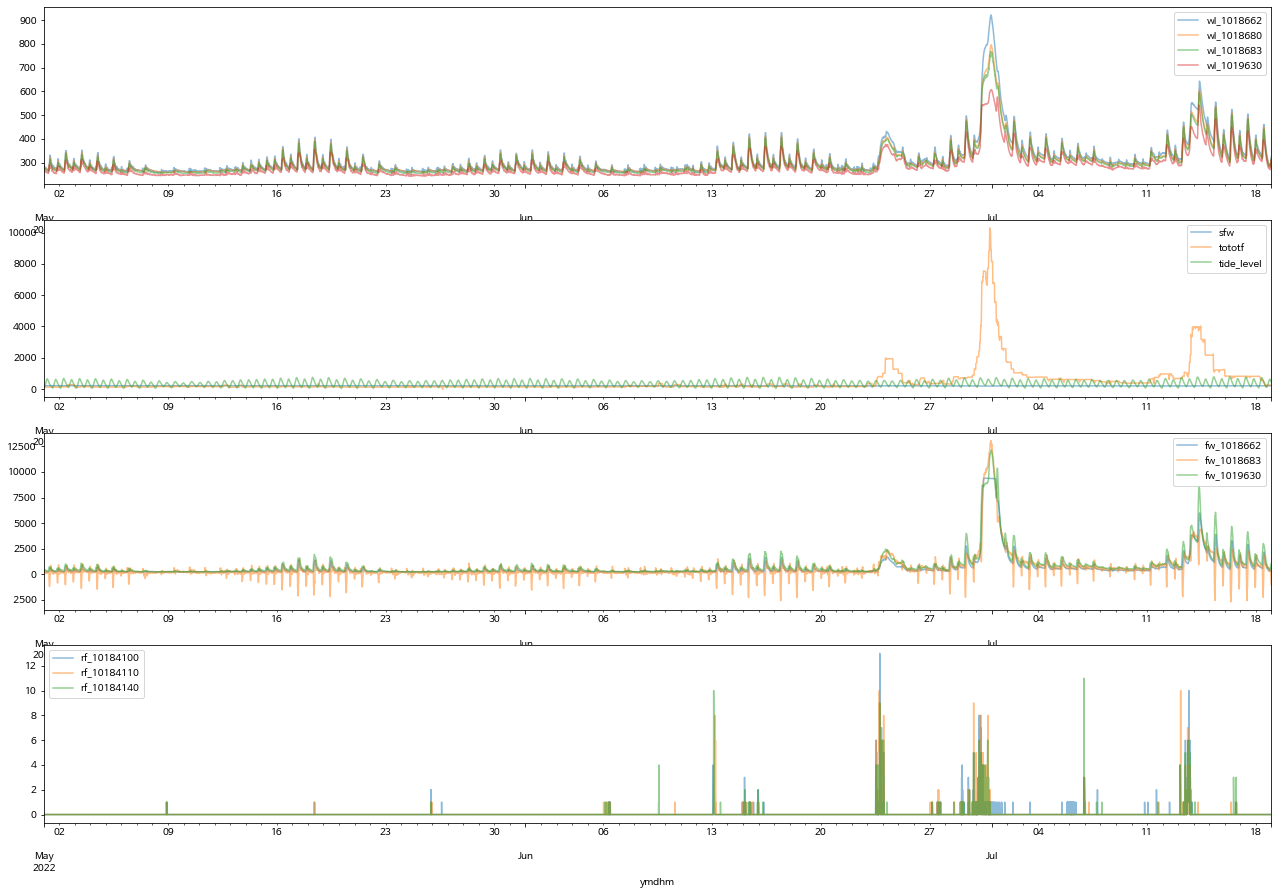

In [ ]:
# 2022
df2022=df.loc['2022']

fig,axes=plt.subplots(nrows=4, ncols=1, figsize=(22,15))
ycol1=['wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630']
ycol2=['sfw', 'tototf', 'tide_level']
ycol3=['fw_1018662', 'fw_1018683', 'fw_1019630']
ycol4=['rf_10184100', 'rf_10184110',	'rf_10184140']

for ycol, ax in zip([ycol1,ycol2,ycol3,ycol4], axes):
  df2022.plot(kind='line', y=ycol, ax=ax, alpha=0.5)

그랜저 인과관계(Granger Causality)란 이전 시차 독립변수들이 종속변수를 예측하는 데 통계적으로 유의미함을 의미한다. 즉, 한 변수의 변화가 시차를 두고 다른 변수에 영향을 미치는 경우를 뜻한다.

출처 : 연합인포맥스(http://news.einfomax.co.kr)

그랜저 인과관계에서 귀무 가설은 해당하는 과거 값의 계수=0. 즉, X가 Y에 영향을 주지 않음. 표의 P-값이 유의 수준(0.05)보다 작은 경우, 귀무 가설 기각. 즉, X가 Y에 영향을 줌. => 독립변수로 채택

In [ ]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False, maxlag=5):    
    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. 

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df  

In [ ]:
variables_list=['wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630', 
                'swl','inf','sfw','ecpc','tototf', 'tide_level',
                'fw_1018662', 'fw_1018683', 'fw_1019630','rf_10184100', 'rf_10184110','rf_10184140']

In [ ]:
grangers_causation_matrix(df, variables=variables_list)

,wl_1018662_x,wl_1018680_x,wl_1018683_x,wl_1019630_x,swl_x,inf_x,sfw_x,ecpc_x,tototf_x,tide_level_x,fw_1018662_x,fw_1018683_x,fw_1019630_x,rf_10184100_x,rf_10184110_x,rf_10184140_x
wl_1018662_y,1.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.000,0.0000
wl_1018680_y,0.0,1.0,0.0,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.000,0.0000
wl_1018683_y,0.0,0.0,1.0,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.000,0.0000
wl_1019630_y,0.0,0.0,0.0,1.0000,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.000,0.0000
swl_y,0.0,0.0,0.0,0.0000,1.0,0.0,0.0000,0.0000,0.0,0.0055,0.0,0.0000,0.0000,0.0000,0.000,0.0001
inf_y,0.0,0.0,0.0,0.0000,0.0,1.0,0.0000,0.0000,0.0,0.0023,0.0,0.0000,0.0000,0.0000,0.000,0.0000
sfw_y,0.0,0.0,0.0,0.0004,0.0,0.0,0.9999,0.0002,0.0,0.0206,0.0,0.0289,0.0011,0.0001,0.000,0.0000
ecpc_y,0.0,0.0,0.0,0.0004,0.0,0.0,0.0000,1.0000,0.0,0.0205,0.0,0.0284,0.0011,0.0001,0.000,0.0000
tototf_y,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0000,1.0,0.0991,0.0,0.0000,0.0000,0.0000,0.000,0.0000
tide_level_y,0.0,0.0,0.0,0.0000,0.0,0.0,0.0877,0.0889,0.0,1.0000,0.0,0.0000,0.0000,0.0875,0.015,0.0009


=> 우리가 가진 독립변수들은 모두 종속변수들(wl)에 통계적으로 유의하게 영향을 줌

# train-test 분리 
- 2022년도 자료만 train으로 사용
- 10분 단위로 shifting하면서 다음 10분 후 예측
  - train(2022-05-01 00:00 ~ 2022-05-31 23:50) => test(2022-06-01 00:00) 
  - train(2022-05-01 00:00 ~ 2022-06-01 00:00) => test(2022-06-01 00:10) 
  - train(2022-05-01 00:00 ~ 2022-06-01 00:10) => test(2022-06-01 00:20) 

In [ ]:
df_2022=df.loc['2022']
df_2022

,swl,inf,sfw,ecpc,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,wl_1018683,fw_1018683,wl_1019630,fw_1019630,rf_10184100,rf_10184110,rf_10184140
ymdhm,,,,,,,,,,,,,,,,
2022-05-01 00:00:00,25.20,739.36,218.73,25.27,124.36,81.0,290.7,337.64,284.2,279.0,0.00,269.3,471.08,0.0,0.0,0.0
2022-05-01 00:10:00,25.20,124.48,218.73,25.27,124.48,72.0,291.7,343.69,284.2,279.0,145.14,266.3,438.33,0.0,0.0,0.0
2022-05-01 00:20:00,25.20,124.20,218.73,25.27,124.20,64.0,290.7,337.64,284.2,279.0,232.22,264.3,417.17,0.0,0.0,0.0
2022-05-01 00:30:00,25.20,124.35,218.73,25.27,124.35,58.0,289.7,331.65,284.2,279.0,302.71,263.3,406.79,0.0,0.0,0.0
2022-05-01 00:40:00,25.19,0.00,218.36,25.64,124.42,58.0,287.7,319.84,284.2,279.0,340.03,264.3,417.17,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-18 23:10:00,25.04,259.23,212.86,31.14,259.23,510.0,288.0,319.84,295.0,299.0,-456.41,306.0,974.40,0.0,0.0,0.0
2022-07-18 23:20:00,25.04,260.46,212.86,31.14,260.46,492.0,287.0,314.01,303.0,304.0,-717.30,308.0,1006.88,0.0,0.0,0.0
2022-07-18 23:30:00,25.04,259.37,212.86,31.14,259.37,475.0,299.0,387.55,307.0,309.0,-843.37,310.0,1039.90,0.0,0.0,0.0


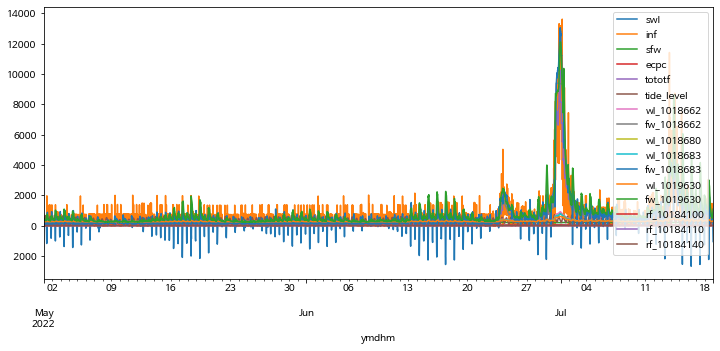

In [ ]:
df_2022.plot()

# 시계열데이터 정상성 확인 

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [ ]:
# df_2022 train 각 열에 ADF Test 
for name, column in df_2022.loc[:'2022-05-31 23:50'].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "swl" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.1096
 No. Lags Chosen       = 21
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "inf" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.7397
 No. Lags Chosen       = 18
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "sfw" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05


In [ ]:
# df_2022 전체 각 열에 ADF Test 
for name, column in df_2022.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "swl" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.1649
 No. Lags Chosen       = 40
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0008. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "inf" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.5836
 No. Lags Chosen       = 40
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "sfw" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

=> 모든 변수가 stationary 하므로 차분 필요 없음

In [ ]:
# df 2021 전체 각 열에 ADF Test 
for name, column in df.loc['2021'].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "swl" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.6933
 No. Lags Chosen       = 29
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "inf" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.9268
 No. Lags Chosen       = 18
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "sfw" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 

In [ ]:
# df 2020 전체 각 열에 ADF Test 
for name, column in df.loc['2020'].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "swl" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.727
 No. Lags Chosen       = 47
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "inf" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.6228
 No. Lags Chosen       = 49
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0053. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "sfw" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

In [ ]:
# df 2019 전체 각 열에 ADF Test 
for name, column in df.loc['2019'].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "swl" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.1294
 No. Lags Chosen       = 39
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "inf" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.6213
 No. Lags Chosen       = 31
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "sfw" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05


In [ ]:
# df 2018 전체 각 열에 ADF Test 
for name, column in df.loc['2018'].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "swl" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.1836
 No. Lags Chosen       = 26
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "inf" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.3358
 No. Lags Chosen       = 48
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "sfw" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 

In [ ]:
# df 2017 전체 각 열에 ADF Test 
for name, column in df.loc['2017'].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "swl" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.0537
 No. Lags Chosen       = 49
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "inf" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8462
 No. Lags Chosen       = 49
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "sfw" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 

In [ ]:
# df 2016 전체 각 열에 ADF Test 
for name, column in df.loc['2016'].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "swl" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.5024
 No. Lags Chosen       = 49
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "inf" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.3247
 No. Lags Chosen       = 47
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "sfw" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 

In [ ]:
# df 2015 전체 각 열에 ADF Test 
for name, column in df.loc['2015'].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "swl" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.5089
 No. Lags Chosen       = 47
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "inf" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.161
 No. Lags Chosen       = 49
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "sfw" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 T

In [ ]:
# df 2014 전체 각 열에 ADF Test 
for name, column in df.loc['2014'].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "swl" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.3835
 No. Lags Chosen       = 49
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "inf" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.8404
 No. Lags Chosen       = 39
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "sfw" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05


In [ ]:
# df 2013 전체 각 열에 ADF Test 
for name, column in df.loc['2013'].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "swl" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.4233
 No. Lags Chosen       = 48
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "inf" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.6792
 No. Lags Chosen       = 31
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "sfw" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 

In [ ]:
# df 2012 전체 각 열에 ADF Test 
for name, column in df.loc['2012'].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "swl" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.0787
 No. Lags Chosen       = 34
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "inf" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.3707
 No. Lags Chosen       = 48
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "sfw" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 

=> 2013~2021 데이터 중 2020 데이터들만 차분 필요

In [ ]:
# 1st difference
df_2020_diff=df.loc['2020'].diff().dropna()

# 다시 ADF test
for name, column in df_2020_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "swl" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -22.651
 No. Lags Chosen       = 46
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "inf" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -19.9488
 No. Lags Chosen       = 49
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "sfw" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05


# 모델링 VAR(p)

In [ ]:
# 최종 변수에 swl, inf, ecpc 제외
df_m=df[['sfw', 'tototf', 'tide_level', 'wl_1018662',
       'fw_1018662', 'wl_1018680', 'wl_1018683', 'fw_1018683', 'wl_1019630',
       'fw_1019630', 'rf_10184100', 'rf_10184110', 'rf_10184140']]
df_2022=df_2022[['sfw', 'tototf', 'tide_level', 'wl_1018662',
       'fw_1018662', 'wl_1018680', 'wl_1018683', 'fw_1018683', 'wl_1019630',
       'fw_1019630', 'rf_10184100', 'rf_10184110', 'rf_10184140']]
df_2020_diff=df_2020_diff[['sfw', 'tototf', 'tide_level', 'wl_1018662',
       'fw_1018662', 'wl_1018680', 'wl_1018683', 'fw_1018683', 'wl_1019630',
       'fw_1019630', 'rf_10184100', 'rf_10184110', 'rf_10184140']]

## p 선택
- AIC 값이 최소인 timestep p 선택

In [ ]:
# order p 선택
p = [10,20,30,40,50,60,70]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2022년 train 데이터로 확인
aic_list=[]
for i in p:
  model = VAR(df_2022.iloc[:4464,:]) #4463 == 2022-05-31 23:50:00
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

20 -8.155785131516588


In [ ]:
# order p 선택
p = [15,16,17,18,19,20,21,22,23,24,25]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2022년 train 데이터로 확인
aic_list=[]
for i in p:
  model = VAR(df_2022.iloc[:4464,:]) #4463 == 2022-05-31 23:50:00
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

17 -8.173423832635597


In [ ]:
# order p 선택
p = [10,20,30,40,50,60,70]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2021년 데이터로 확인
for i in p:
  model = VAR(df_m.loc['2021'])
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

30 -8.173423832635597


In [ ]:
# order p 선택
p = [25,26,27,28,29,30,31,32,33,34,35]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2021년 데이터로 확인
for i in p:
  model = VAR(df_m.loc['2021'])
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

27 -8.173423832635597


In [ ]:
# order p 선택
p = [30,40,50,60,70,80,90]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2020년 데이터로 확인
for i in p:
  model = VAR(df_2020_diff)
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

50 -8.173423832635597


In [ ]:
# order p 선택
p = [45,46,47,48,49,50,51,52,53,54,55]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2020년 데이터로 확인
for i in p:
  model = VAR(df_2020_diff)
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

47 -8.173423832635597


In [ ]:
# order p 선택
p = [20,30,40,50,60,70]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2019년 데이터로 확인
for i in p:
  model = VAR(df_m.loc['2019'])
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

30 -8.173423832635597


In [ ]:
# order p 선택
p = [25,26,27,28,29,30,31,32,33,34,35]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2019년 데이터로 확인
for i in p:
  model = VAR(df_m.loc['2019'])
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

27 -8.173423832635597


In [ ]:
# order p 선택
p = [20,30,40,50,60,70]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2018년 데이터로 확인
for i in p:
  model = VAR(df_m.loc['2018'])
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

40 -8.173423832635597


In [ ]:
# order p 선택
p = [35,36,37,38,39,40,41,42,43,44,45]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2018년 데이터로 확인
for i in p:
  model = VAR(df_m.loc['2018'])
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

37 -8.173423832635597


In [ ]:
# order p 선택
p = [20,30,40,50,60,70]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2017년 데이터로 확인
for i in p:
  model = VAR(df_m.loc['2017'])
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

40 -8.173423832635597


In [ ]:
# order p 선택
p = [35,36,37,38,39,40,41,42,43,44,45]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2017년 데이터로 확인
for i in p:
  model = VAR(df_m.loc['2017'])
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

37 -8.173423832635597


In [ ]:
# order p 선택
p = [20,30,40,50,60,70]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2016년 데이터로 확인
for i in p:
  model = VAR(df_m.loc['2016'])
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

40 -8.173423832635597


In [ ]:
# order p 선택
p = [35,36,37,38,39,40,41,42,43,44,45]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2016년 데이터로 확인
for i in p:
  model = VAR(df_m.loc['2016'])
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

37 -8.173423832635597


In [ ]:
# order p 선택
p = [20,30,40,50,60,70]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2015년 데이터로 확인
for i in p:
  model = VAR(df_m.loc['2015'])
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

40 -8.173423832635597


In [ ]:
# order p 선택
p = [35,36,37,38,39,40,41,42,43,44,45]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2015년 데이터로 확인
for i in p:
  model = VAR(df_m.loc['2015'])
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

37 -8.173423832635597


In [ ]:
# order p 선택
p = [20,30,40,50,60,70]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2014년 데이터로 확인
for i in p:
  model = VAR(df_m.loc['2014'])
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

40 -8.173423832635597


In [ ]:
# order p 선택
p = [35,36,37,38,39,40,41,42,43,44,45]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2014년 데이터로 확인
for i in p:
  model = VAR(df_m.loc['2014'])
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

37 -8.173423832635597


In [ ]:
# order p 선택
p = [20,30,40,50]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2013년 데이터로 확인
for i in p:
  model = VAR(df_m.loc['2013'])
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

40 -8.173423832635597


In [ ]:
# order p 선택
p = [35,36,37,38,39,40,41,42,43,44,45]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2013년 데이터로 확인
for i in p:
  model = VAR(df_m.loc['2013'])
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

37 -8.173423832635597


In [ ]:
# order p 선택
p = [20,30,40,50]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2012년 데이터로 확인
for i in p:
  model = VAR(df_m.loc['2012'])
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

40 -8.173423832635597


In [ ]:
# order p 선택
p = [35,36,37,38,39,40,41,42,43,44,45]  # 몇개 timestep 이전까지 모델에 반영할 것인지

# 2012년 데이터로 확인
for i in p:
  model = VAR(df_m.loc['2012'])
  results = model.fit(i)
  aic_list.append(results.aic)
idx=aic_list.index(min(aic_list))
print(p[idx], min(aic_list))

37 -8.173423832635597


=> 년도, p
- 2022, 17
- 2021, 27
- 2020, 47
- 2019, 27
- 2018, 37
- 2017, 37
- 2016, 37
- 2015, 37
- 2014, 37
- 2013, 37
- 2012, 37


In [ ]:
np.mean([17,27,47,27,37,37,37,37,37,37,37])

34.27272727272727

## VAR(34) 예시

In [ ]:
df_2022.iloc[4464:11376,:] 

,sfw,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,wl_1018683,fw_1018683,wl_1019630,fw_1019630,rf_10184100,rf_10184110,rf_10184140
ymdhm,,,,,,,,,,,,,
2022-06-01 00:00:00,218.36,140.60,162.0,279.0,269.40,276.0,274.0,8.23,269.0,471.08,0.0,0.0,0.0
2022-06-01 00:10:00,218.36,140.78,151.0,281.0,280.22,277.0,274.0,28.82,267.0,449.12,0.0,0.0,0.0
2022-06-01 00:20:00,218.73,140.90,141.0,284.0,296.87,277.0,274.0,12.35,264.0,417.17,0.0,0.0,0.0
2022-06-01 00:30:00,218.36,140.94,130.0,285.0,302.53,277.0,274.0,53.52,261.0,386.43,0.0,0.0,0.0
2022-06-01 00:40:00,218.36,140.63,120.0,284.0,296.87,278.0,274.0,107.04,259.0,366.60,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-18 23:10:00,212.86,259.23,510.0,288.0,319.84,295.0,299.0,-456.41,306.0,974.40,0.0,0.0,0.0
2022-07-18 23:20:00,212.86,260.46,492.0,287.0,314.01,303.0,304.0,-717.30,308.0,1006.88,0.0,0.0,0.0
2022-07-18 23:30:00,212.86,259.37,475.0,299.0,387.55,307.0,309.0,-843.37,310.0,1039.90,0.0,0.0,0.0


In [ ]:
df_test=df_2022.loc['2022-06-01 00:00':,['wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630']]
df_forecast=pd.DataFrame(columns=df_2022.columns, index=df_test.index)

In [ ]:
# 모델 학습
model = VAR(df_2022.iloc[:4464,:]) # 2022-05-31 23:50까지
fitted = model.fit(34)

# 시차 개수 
lag = fitted.k_ar

# 예측을 위한 마지막 p timestep만 추출 -> 시차(lag)
forecast_input = df_2022.iloc[:4464,:].values[-lag:]

fc=fitted.forecast(y=forecast_input, steps=1) # 바로 다음 step 1개 예측
df_forecast.iloc[0]=fc
df_forecast.head()

,sfw,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,wl_1018683,fw_1018683,wl_1019630,fw_1019630,rf_10184100,rf_10184110,rf_10184140
ymdhm,,,,,,,,,,,,,
2022-06-01 00:00:00,218.358548,141.9659,163.428369,280.393444,275.940379,277.475521,274.692344,40.775395,268.644655,462.704002,0.002192,-0.006736,-0.000781
2022-06-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-01 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## VAR(34) 학습, 예측, 시각화

In [ ]:
# 전체 test 기간 VAR(34) 모델 학습 및 예측

for i in range(6912):
  model=VAR(df_2022.iloc[:4464+i,:]) 
  fitted = model.fit(34)
  lag = fitted.k_ar
  forecast_input = df_2022.iloc[:4464+i,:].values[-lag:]
  fc=fitted.forecast(y=forecast_input, steps=1) # 바로 다음 step 1개 예측
  df_forecast.iloc[i]=fc

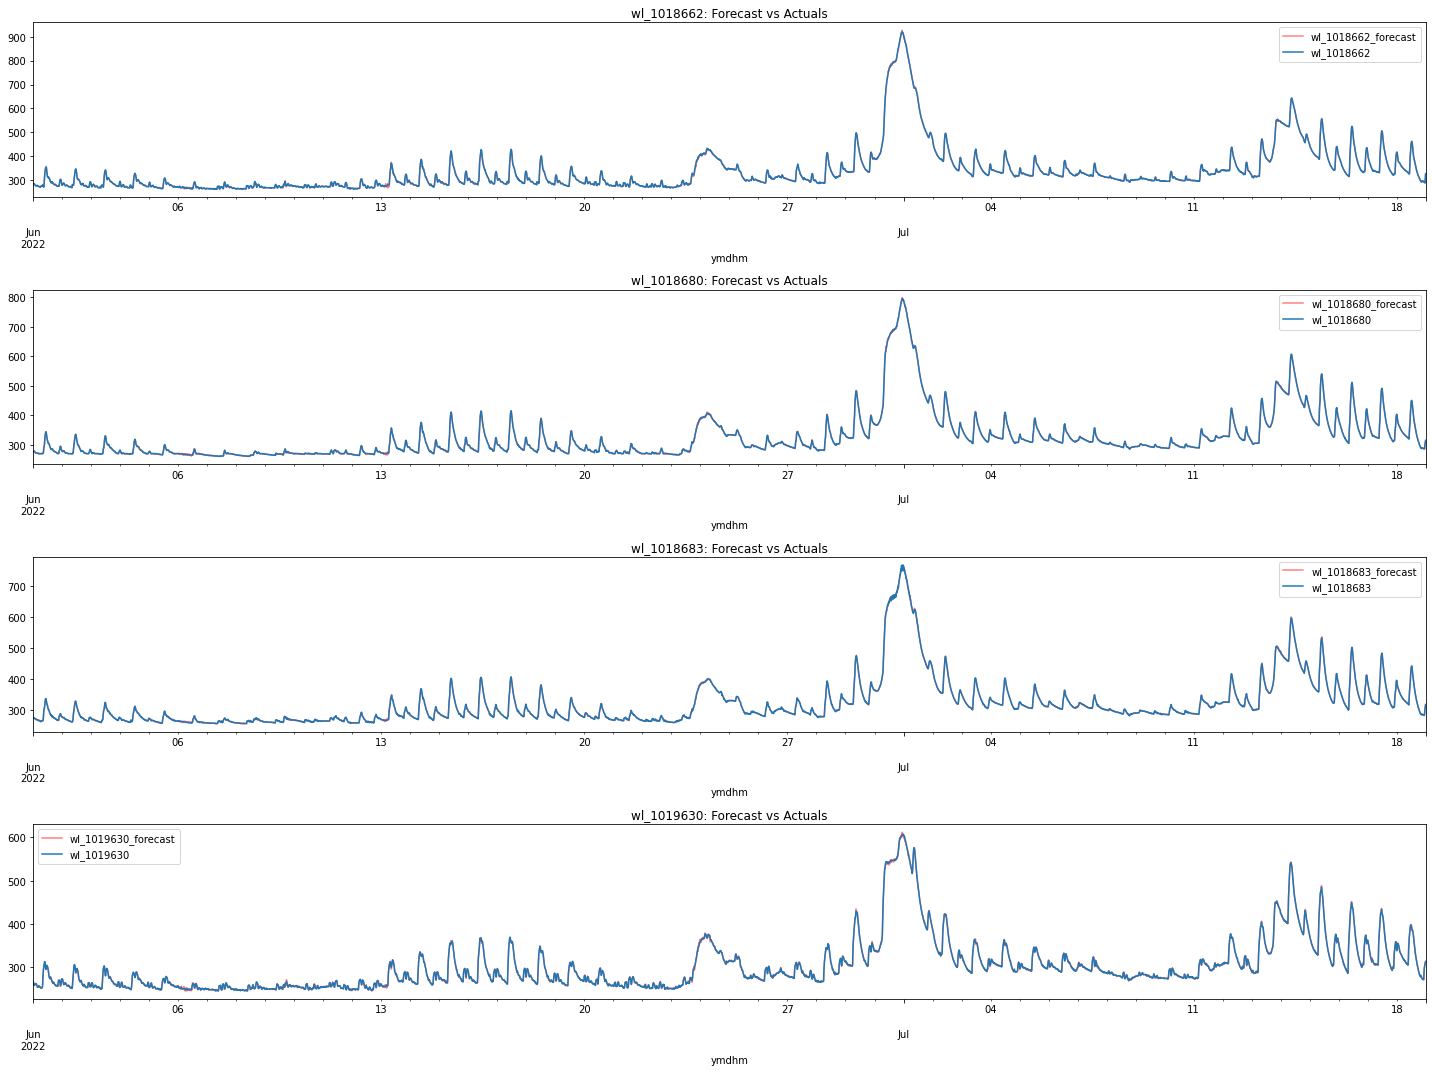

In [ ]:
# 시각화
df_forecast_y=df_forecast[['wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630']]
df_forecast_y.columns=['wl_1018662_forecast', 'wl_1018680_forecast', 'wl_1018683_forecast', 'wl_1019630_forecast']
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20,15))

for col, ax in zip(['wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630'], axes):
    df_forecast_y.plot(y=[col+'_forecast'], ax=ax, alpha=0.5, color='r', legend=True).autoscale(axis='x',tight=True)
    df_test[col].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
plt.tight_layout()
plt.show()

In [ ]:
submission=df_forecast[['wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630']]
submission.reset_index(drop=False, inplace=True)
submission['ymdhm']=submission['ymdhm'].dt.strftime('%Y-%m-%d %H:%M')
submission.set_index('ymdhm', inplace=True)

In [ ]:
submission

,wl_1018662,wl_1018680,wl_1018683,wl_1019630
ymdhm,,,,
2022-06-01 00:00,280.393444,277.475521,274.692344,268.644655
2022-06-01 00:10,281.650185,276.402867,273.951231,267.238006
2022-06-01 00:20,282.764189,276.825949,273.942286,264.747595
2022-06-01 00:30,285.315187,277.826235,273.221274,261.043767
2022-06-01 00:40,285.597462,278.287083,273.215396,258.78204
...,...,...,...,...
2022-07-18 23:10,287.692513,293.204864,298.794852,306.200601
2022-07-18 23:20,289.325242,302.608096,304.350082,308.615429
2022-07-18 23:30,294.596936,307.486101,307.472102,309.5884


In [ ]:
submission.to_csv('/content/drive/Shareddrives/팔당댐/제출/VAR.csv')